In [23]:
# initialisation
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from binance.client import Client
from klychi import api_key, api_secret

client = Client(api_key, api_secret)

# to display all of the columns and rows and max width
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%config InlineBackend.figure_format = 'svg'  # improves the quality of graphs
%matplotlib inline

matplotlib.rc('xtick', labelsize=12)  # set size of the axis font
matplotlib.rc('ytick', labelsize=12)
matplotlib.style.use('ggplot')

In [2]:
def organise_binance_klines(df, save_csv=False, csv_name=''):
    col_names = ['open_time_unix', 'open', 'high', 'low', 'close', 'volume', 
                 'close_time_unix', 'quote_asset_volume', 'number_of_trades', 
                 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    
    df_new = df.copy()
    
    # change unix time to datetime; binance show time in ms
    df_new['candle-start'] = pd.to_datetime(df_new[0], unit='ms')
    df_new['candle-end'] = pd.to_datetime(df_new[6], unit='ms')
    
    # rename columns
    df_new.columns = col_names + ['candle-start', 'candle-end']
    
    # set index and drop extra columns
    df_new.set_index(['candle-end'], inplace=True)
    
    # change dtypes of data from object to float/int
    df_new = df_new.astype({'open': 'float64', 'high': 'float64', 'low': 'float64', 'close': 'float64',
                            'volume': 'float64','quote_asset_volume': 'float64', 'number_of_trades': 'int64',
                            'taker_buy_base_asset_volume': 'float64', 
                            'taker_buy_quote_asset_volume': 'float64'})
    
    if save_csv:
        df_new.to_csv(path_or_buf=str(csv_name) + '.csv')
    
    return df_new

In [29]:
# get historical data
# download historical klines from binance for eth/usdt pair
eth_usdt1h_raw = pd.DataFrame(client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_1HOUR, '1 Jan 2017'))

In [30]:
# organise eth/usdt data
eth_usdt1h = organise_binance_klines(eth_usdt1h_raw, save_csv=True, csv_name='eth_usdt_1h_2017')

# describe downloaded data
print(eth_usdt1h.info())
print()
print(eth_usdt1h.head())
print()
print(eth_usdt1h.describe())

In [3]:
# read data from the csv file
eth_usdt1h = pd.read_csv('eth_usdt_1h_2017.csv', index_col='candle-start')

eth_usdt1h.index = pd.to_datetime(eth_usdt1h.index)
eth_usdt1h['candle-end'] = pd.to_datetime(eth_usdt1h['candle-end'])

# describe downloaded data
print(eth_usdt1h.info())
print()
print(eth_usdt1h.head())
print()
print(eth_usdt1h.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 17382 entries, 2017-08-17 04:00:00.000 to 2019-08-14 21:00:00
Data columns (total 13 columns):
open_time_unix                  17382 non-null int64
open                            17382 non-null float64
high                            17382 non-null float64
low                             17382 non-null float64
close                           17382 non-null float64
volume                          17382 non-null float64
close_time_unix                 17382 non-null int64
quote_asset_volume              17382 non-null float64
number_of_trades                17382 non-null int64
taker_buy_base_asset_volume     17382 non-null float64
taker_buy_quote_asset_volume    17382 non-null float64
ignore                          17382 non-null float64
candle-end                      17382 non-null object
dtypes: float64(9), int64(3), object(1)
memory usage: 1.9+ MB
None

                         open_time_unix    open    high    low   close     volume  c

In [4]:
# add 17 and 48 EMA to timeseries
eth_usdt1h['ema17'] = eth_usdt1h['close'].ewm(span=17, min_periods=17, adjust=False).mean()
eth_usdt1h['ema48'] = eth_usdt1h['close'].ewm(span=48, min_periods=48, adjust=False).mean()
eth_usdt1h.dropna(inplace=True)

print(eth_usdt1h.head())

                         open_time_unix    open    high     low   close     volume  close_time_unix  quote_asset_volume  number_of_trades  taker_buy_base_asset_volume  taker_buy_quote_asset_volume        ignore               candle-end       ema17       ema48
candle-start                                                                                                                                                                                                                                                       
2017-08-19 03:00:00.000   1503111600000  298.64  298.64  292.83  293.22   66.73802    1503115199999        19668.731698                85                     36.15918                  10663.461450  55410.139053  2017-08-19 03:59:59.999  296.786184  300.173030
2017-08-19 04:00:00.000   1503115200000  294.69  297.19  291.87  291.87   42.99260    1503118799999        12631.829074                34                      4.84952                   1434.715001  55052.778410  2017-08-

### Lets see how the downloaded data looks

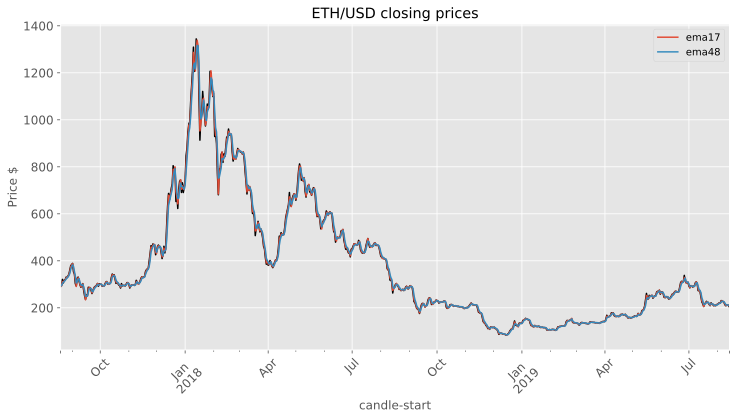

In [25]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot()
ax1.set_xlabel(xlabel='Time', fontsize=12)
ax1.set_ylabel(ylabel='Price $', fontsize=12)

eth_usdt1h['close'].resample('D').mean().plot(ax=ax1, color='black')
eth_usdt1h[['ema17', 'ema48']].resample('D').mean().plot(ax=ax1)

plt.title('ETH/USD closing prices')

plt.xticks(rotation=45)

plt.show()

### lets zoom in a little

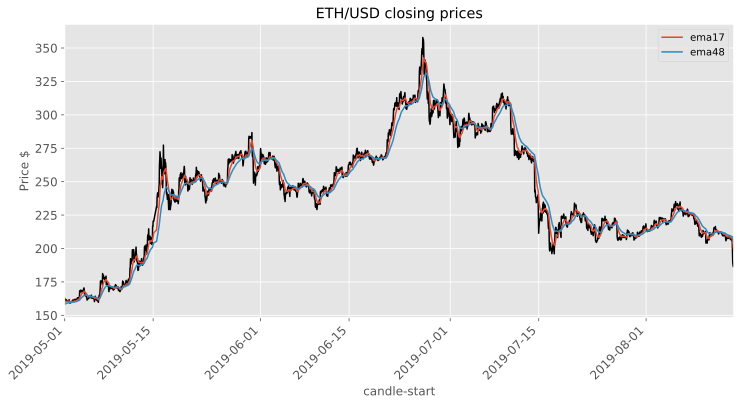

In [26]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot()
ax1.set_xlabel(xlabel='Time', fontsize=12)
ax1.set_ylabel(ylabel='Price $', fontsize=12)

eth_usdt1h['close'].loc['2019-05-01':].plot(ax=ax1, color='black')
eth_usdt1h[['ema17', 'ema48']].loc['2019-05-01':].plot(ax=ax1)

plt.title('ETH/USD closing prices')

plt.xticks(rotation=45)

plt.show()

In [ ]:
def do_backtest(data):
    """
    function allows to iterate through a dataFrame and place trades according to trading rules.
    at the end it outputs updated dataFrame and order book with all the trades performed
    substitute commission for different assets
    """

    equity_amount = 10000  # set the amount of capital to trade with
    eq_am_static = 10000

    open_order = 0

    commission = 0.001  # 0.1 % commission per trade on binance

    order_book = pd.DataFrame()

    data['equity'] = 0.00  # to make values floats
    data['currency'] = 'currency'

    # trading rule using only Technical Indicators
    data['trade'] = np.where(data['ema17'] > data['ema48'], 1, np.where(data['ema17'] < data['ema48'], -1, 0))

    for index, row in data.iterrows():  # using only Technical Indicators

        if row['trade'] == 1 and open_order == 0:  # check buy signal and if there's no open order
            open_order = 1  # open order and buy with formula below
            commission_payable = equity_amount * commission  # commission for cryptocurrencies
            equity_amount = ((equity_amount - commission_payable) / data.loc[index, 'close'])
            data.at[index, 'equity'] = equity_amount  # record amount of money we have
            data.at[index, 'currency'] = 'ETH'  # change to ETH, BTC, EUR, etc.
            order_book_ti = data.loc[:, ['close', 'vote', 'trade', 'equity', 'currency']]

        elif row['trade'] == -1 and open_order == 1:  # check sell signal
            open_order = 0  # close previously opened order and sell with below formula
            commission_payable = equity_amount * commission
            equity_amount = ((equity_amount - commission_payable) * data.loc[index, 'close'])
            data.at[index, 'equity'] = equity_amount  # record amount of money we have
            data.at[index, 'currency'] = 'USD'
            order_book_ti = data.loc[:, ['close', 'vote', 'trade', 'equity', 'currency']]


    order_book = order_book[(order_book[['Equity']] != 0).all(axis=1)]  # to record only trades
    order_book_ti = order_book_ti[(order_book_ti[['Equity_TI']] != 0).all(axis=1)]  # to record only trades
    order_book_svc = order_book_svc[(order_book_svc[['Equity_svc']] != 0).all(axis=1)]  # to record only trades

    performance = order_book[(order_book[['Trade']] != 1).all(axis=1)]  # to track only values in USD
    performance_ti = order_book_ti[(order_book_ti[['Trade_TI']] != 1).all(axis=1)]  # to track only values in USD
    performance_svc = order_book_svc[(order_book_svc[['Trade_svc']] != 1).all(axis=1)]  # to track only values in USD

    n_trades = len(order_book.index)  # get number of trades performed
    ann_return = performance.Equity.iloc[-1]  # get last value of the equity column in USD
    pct_ann_return = (ann_return - eq_am_static) / eq_am_static * 100

    n_trades_ti = len(order_book_ti.index)  # get number of trades performed
    ann_return_ti = performance_ti.Equity_TI.iloc[-1]  # get last value of the equity column in USD
    pct_ann_return_ti = (ann_return_ti - eq_am_ti_static) / eq_am_ti_static * 100

    n_trades_svc = len(order_book_svc.index)  # get number of trades performed
    ann_return_svc = performance_svc.Equity_svc.iloc[-1]  # get last value of the equity column in USD
    pct_ann_return_svc = (ann_return_svc - eq_am_ml) / eq_am_ml * 100

    print("Results using Technical Indicators and SVC")
    print("Final portfolio value: {0:0.2f} USD".format(ann_return))
    print("Total return: {0:0.2f} %".format(pct_ann_return))
    # print("Sharpe Ratio: {}".format(sharpe))
    print("Total number of trades performed: {}".format(n_trades))
    print()

    print("Results using Technical Indicators")
    print("Final portfolio value: {0:0.2f} USD".format(ann_return_ti))
    print("Total return: {0:0.2f} %".format(pct_ann_return_ti))
    # print("Sharpe Ratio: {}".format(sharpe))
    print("Total number of trades performed: {}".format(n_trades_ti))
    print()

    print("Results using SVC")
    print("Final portfolio value: {0:0.2f} USD".format(ann_return_svc))
    print("Total return: {0:0.2f} %".format(pct_ann_return_svc))
    # print("Sharpe Ratio: {}".format(sharpe))
    print("Total number of trades performed: {}".format(n_trades_svc))
    print()

    # plotting performance and prices
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(30, 20))  # figure with 2 subplots and shared x axis
    f.subplots_adjust(hspace=0)  # remove space between subplots
    x1 = data[['Close']]  # .resample('W' ).mean()  # plot EUR/USD price resampled weekly
    ax1.plot(x1)
    # ax1.set_title( 'System Performance', fontsize=23 )
    ax1.set_ylabel('ETH / USD Price', fontsize=23)
    # ax1.grid()  # print vertical lines that show buy/sell activity
    # for index, row in order_book.iterrows():
    #     trade = row[ 'Trade' ]
    #     if trade == 1:  # try using ax1.vlines
    #         ax1.axvline( x=index, color='green' )
    #     elif trade == -1:
    #         ax1.axvline( x=index, color='red' )

    x2 = performance[['Equity']]
    ax2.set_ylabel('System Returns in $', fontsize=23)
    ax2.plot(x2)

    x3 = performance_ti[['Equity_TI']]
    ax3.set_ylabel('Returns in $ using TI', fontsize=23)
    ax3.plot(x3)

    x4 = performance_svc[['Equity_svc']]
    ax4.set_ylabel('Returns in $ using SVC', fontsize=23)
    ax4.set_xlabel('Time', fontsize=25)
    ax4.plot(x4)

    plt.show()

    return data, order_book, order_book_ti, order_book_svc, equity_amount, equity_amount_ti, equity_amount_ml


In [19]:
eth_usdt1h.index = pd.to_datetime(eth_usdt1h.index)
eth_usdt1h['candle-end'] = pd.to_datetime(eth_usdt1h['candle-end'])
print(eth_usdt1h.index.dtype)
print(eth_usdt1h['candle-end'].dtype)

datetime64[ns]
datetime64[ns]
